In [ ]:
import tqdm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from arch import arch_model

To find the periods with low and high volatility, we could use the VIX index. However, this uses *expected* volatility, while we are more interested in *actual* volatility. Therefore, we calculate rolling volatility for all days, and use the 10% and 90% quantiles to define low and high volatility periods. We find the rolling volatility for a day $t$ with this formula:

$$
\text{volatility}(t) = \sqrt{\frac{1}{N} \sum_{i=0}^{N-1} (r_{t-i} - \bar{r})^2}
$$

Where $r_x$ is the return on day $x$, $\bar{r}$ is the average return, and $N$ is the number of days in the rolling window. We use a rolling window of 21 days (trading days in a month), and use the log returns (scaled by 100). We then smooth it using the 10-day moving average to stabilise the periods, as one day of high volatility could inadvertedly skew the results. Note that by using the stocks own quantiles we define the periods of low and high volatility based on the volatility of the stock itself, which is not an objective measure of the volatility of the stock compared to the market.

In [7]:
ticker = "AAPL"
csv_filepath = f"data/{ticker}.csv"

df = pd.read_csv(csv_filepath, index_col='Date', parse_dates=True)
df['Return'] = np.pad(np.diff(np.log(df['Close'])) * 100, (1, 0), 'constant', constant_values=np.nan)
df.index = pd.to_datetime(df.index, utc=True)

In [8]:
mean_return = df['Return'].mean()
df['e'] = df['Return'] - mean_return
df['Volatility'] = (df['e']) ** 2
df['unsmoothed_rolling_vol'] = df['Volatility'].rolling(window=21).mean()
# smooth it with 10 day MA
df['Rolling volatility'] = df['unsmoothed_rolling_vol'].rolling(window=10).mean()

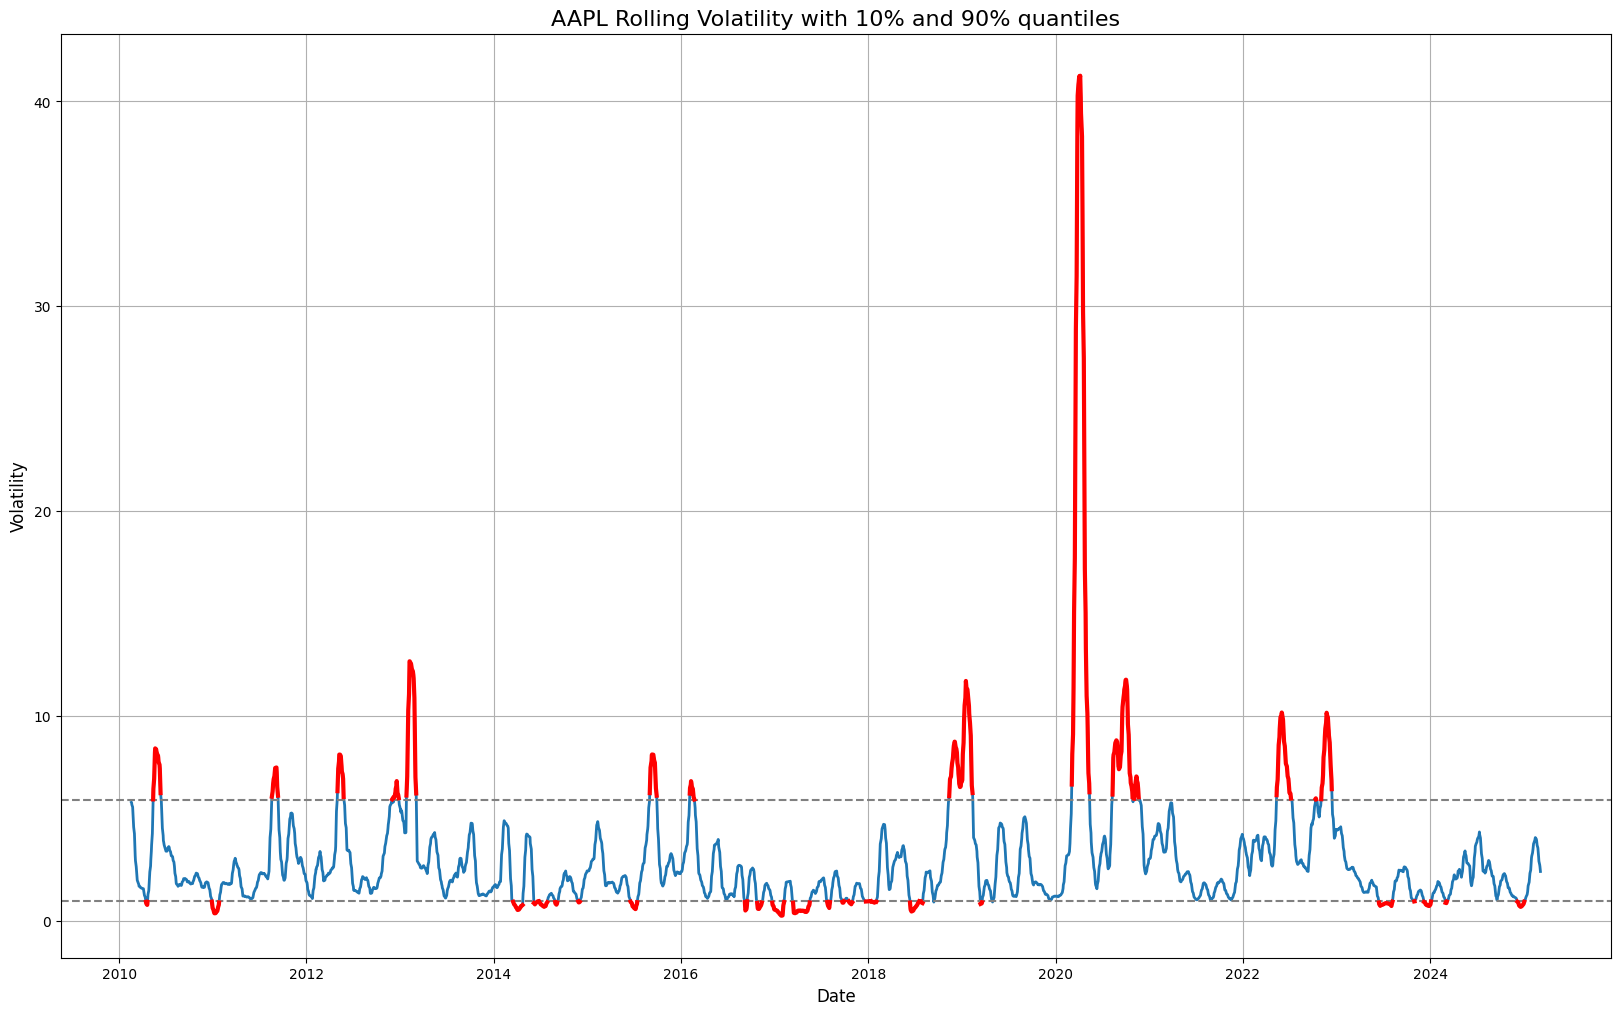

In [9]:
quantiles = df['Rolling volatility'].quantile([0.1, 0.9])
q_low = quantiles.loc[0.1]
q_high = quantiles.loc[0.9]

under = df['Rolling volatility'].where(
    (df['Rolling volatility'] < q_low)
)
over = df['Rolling volatility'].where(
    (df['Rolling volatility'] > q_high)
)
plt.figure(figsize=(20, 12))
plt.plot(df.index, df['Rolling volatility'], label="Rolling Volatility", linewidth=2)
plt.axhline(y=q_low, color='gray', linestyle='--', label='10% quantile')
plt.axhline(y=q_high, color='gray', linestyle='--', label='90% quantile')
plt.plot(df.index, over, color='red', linewidth=3)
plt.plot(df.index, under, color='red', linewidth=3)
plt.title(f"{ticker} Rolling Volatility with 10% and 90% quantiles", fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.grid(True)
plt.show()

Here we test GARCH and GJR-GARCH models and look at their RMSE for different volatility periods. The results look as expected.

I thought we would just plug-and-play a bunch of different models, but based on [this](https://arch.readthedocs.io/en/latest/univariate/forecasting.html) it seems like we might need to use some other adjustments for things like EGARCH. Anyways, there is lots to try by just plotting a few ARCH-models and trying different p and q values, and we won't struggle with having something to talk about if we have 3+ models to compare.

100%|██████████| 3544/3544 [00:31<00:00, 111.87it/s]


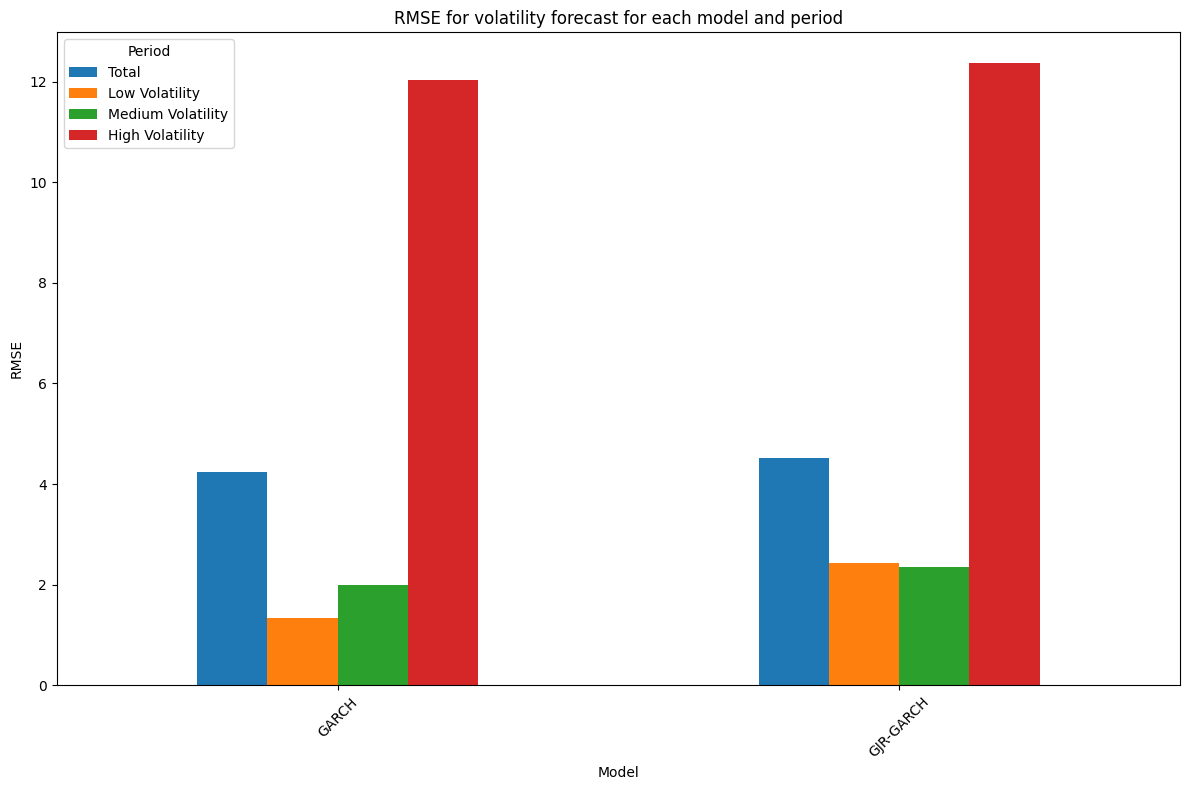

In [10]:
models = [
    {'name': 'GARCH', 'vol': 'GARCH', 'p': 1, 'q': 1},
    {'name': 'GJR-GARCH', 'vol': 'GARCH', 'p': 1, 'o': 1, 'q': 1},
]

forecast_results = {}
for model_spec in models:
    forecasts, actuals, regimes, dates = [], [], [], []
    for t in tqdm.tqdm(range(252, len(df) - 21)):
        train_data = df.iloc[t-252:t]['e']
        if not np.isfinite(train_data).all():
            continue
        model = arch_model(
            train_data, mean='Zero', vol=model_spec['vol'], 
            p=model_spec['p'], q=model_spec['q'], o=model_spec.get('o', 0)
        )
        res = model.fit(disp='off')
        forecasts_horizon = res.forecast(horizon=21)
        f_t = forecasts_horizon.variance.iloc[0, :].mean()
        actual = df['unsmoothed_rolling_vol'].iloc[t+21]
        regime = df['Rolling volatility'].iloc[t+21]
        forecasts.append(f_t)
        actuals.append(actual)
        regimes.append(regime)
        dates.append(df.index[t+21])
    
    forecast_df = pd.DataFrame({'forecast': forecasts, 'actual': actuals, 'regime': regimes}, index=dates)
    forecast_df = forecast_df[np.isfinite(forecast_df['forecast']) & np.isfinite(forecast_df['actual'])]
    
    rmse_overall = np.sqrt(np.mean((forecast_df['forecast'] - forecast_df['actual'])**2))
    low_vol = forecast_df[forecast_df['regime'] < q_low]
    rmse_low = np.sqrt(np.mean((low_vol['forecast'] - low_vol['actual'])**2)) if not low_vol.empty else np.nan
    high_vol = forecast_df[forecast_df['regime'] > q_high]
    rmse_high = np.sqrt(np.mean((high_vol['forecast'] - high_vol['actual'])**2)) if not high_vol.empty else np.nan
    med_vol = forecast_df[(forecast_df['regime'] >= q_low) & (forecast_df['regime'] <= q_high)]
    rmse_med = np.sqrt(np.mean((med_vol['forecast'] - med_vol['actual'])**2)) if not med_vol.empty else np.nan
    
    forecast_results[model_spec['name']] = {
        'rmse_overall': rmse_overall, 'rmse_low': rmse_low, 
        'rmse_med': rmse_med, 'rmse_high': rmse_high, 'forecast_df': forecast_df
    }

rmse_data = {
    'Total': [forecast_results[model]['rmse_overall'] for model in forecast_results],
    'Low Volatility': [forecast_results[model]['rmse_low'] for model in forecast_results],
    'Medium Volatility': [forecast_results[model]['rmse_med'] for model in forecast_results],
    'High Volatility': [forecast_results[model]['rmse_high'] for model in forecast_results]
}
rmse_df = pd.DataFrame(rmse_data, index=[model['name'] for model in models])
rmse_df.plot(kind='bar', figsize=(12, 8))
plt.title('RMSE for volatility forecast for each model and period')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Period')
plt.tight_layout()
plt.show()